In [20]:
from __future__ import print_function, division

import caffe
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
% matplotlib inline

from model import ClassModel
from tools.dataset import SPCDataset
from tools.preprocessing import aspect_resize, convert_to_8bit

# Classify
1. Preprocessing
2. Evaluate

First let's load the images to understand our data
- It would appear from this random sample, that there are definitely a few fish eggs, which are annotated with the yellow box, that we want to detect

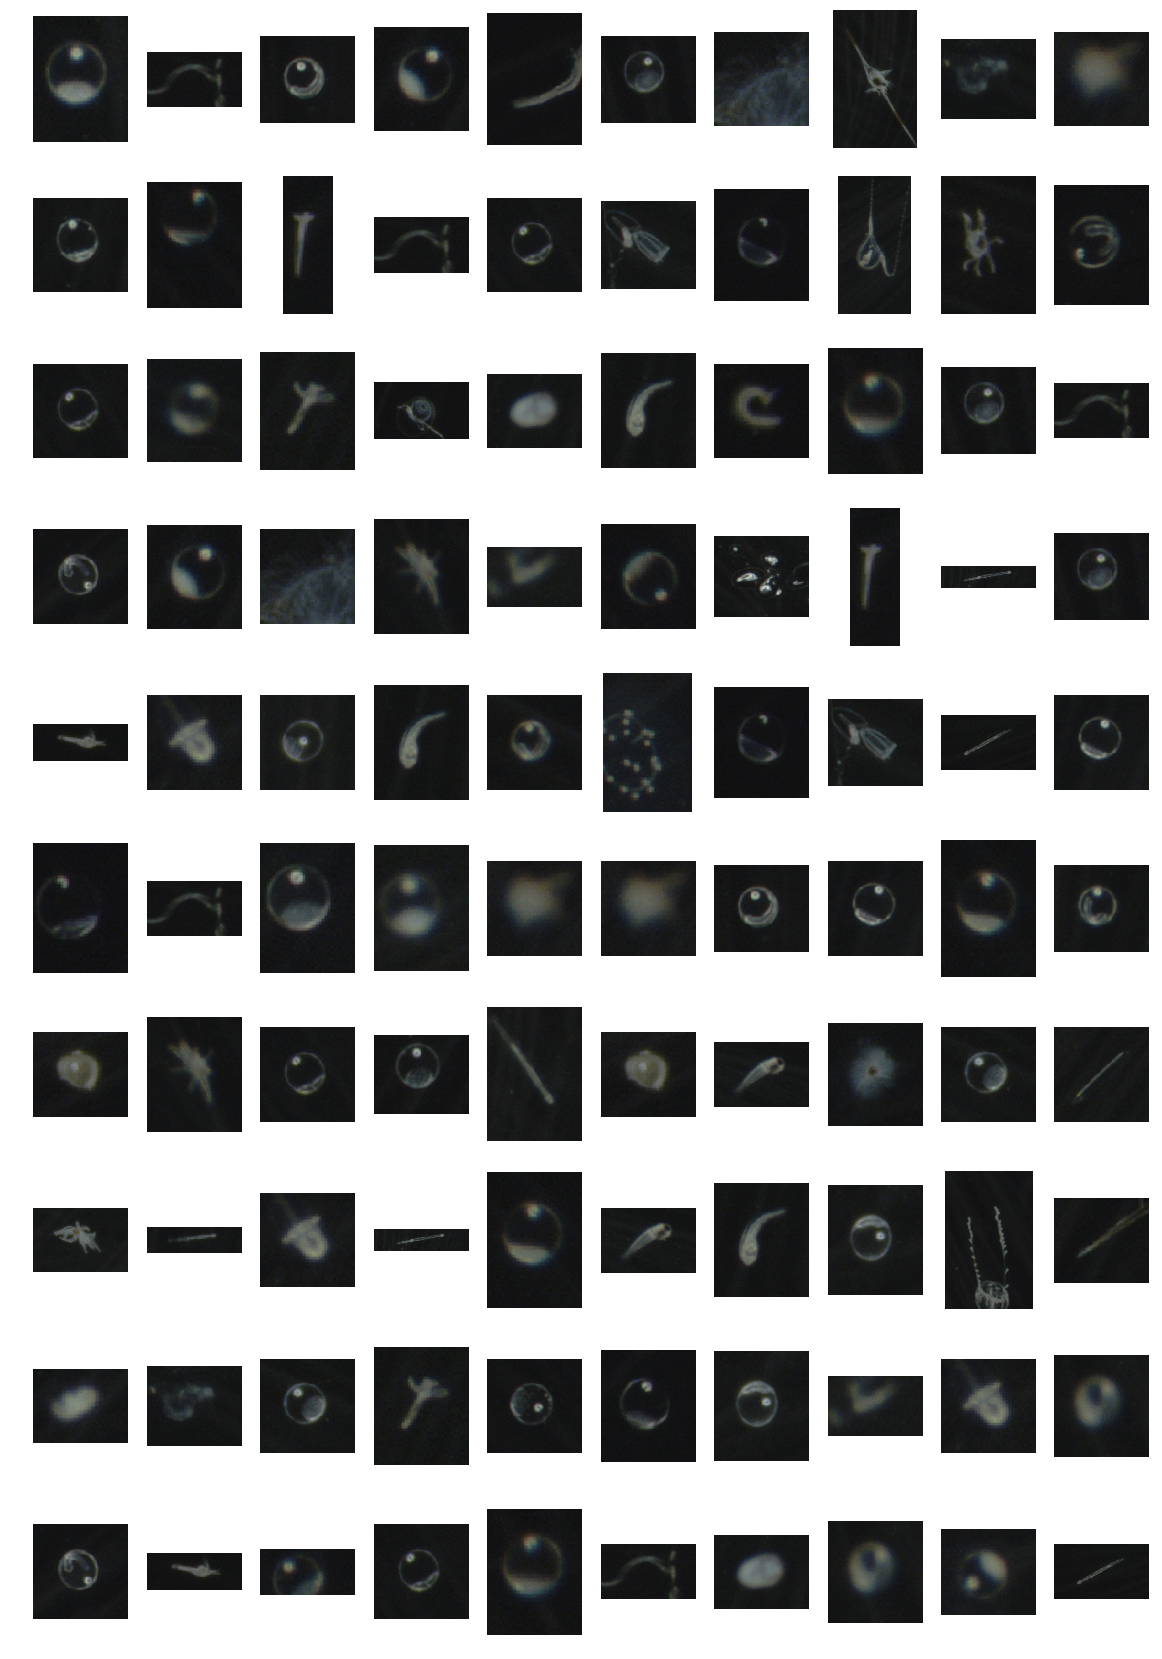

In [6]:
ROOT = '/data6/lekevin/cayman'
phase = 'val'
img_dir = ROOT + '/rawdata'
csv_filename = ROOT + '/data/4/data_{}.csv'
dataset = {phase: SPCDataset(csv_filename=csv_filename.format(phase), img_dir=img_dir, phase=phase)}
numRows, numCols = 10,10
df = dataset[phase].data.sample(n=numRows*numCols)
path_map = {i:os.path.join(img_dir, '{}_SPC_Images_3-COLOR'.format(i)) for i in ['EC1', 'EC2', 'EC3']}
df['path'] = df['day'].map(path_map).astype(str) + '/' + df['image']
fig, axarr = plt.subplots(numRows, numCols, figsize=(20,30))
for i in range(numRows):
    for j in range(numCols):
        idx = np.random.choice(df.index)
        filename = os.path.join(img_dir, '{}_SPC_Images_3-COLOR'.format(df.loc[idx]['day']), df.loc[idx]['image'])
        img = plt.imread(filename)
        axarr[i,j].imshow(img)
        axarr[i,j].set_axis_off()
plt.show()

As our next step, lets prepare our model by setting it up in it's deploy stage

In [7]:
# Initialize paths to deploy prototxt and weights
deploy_proto = ROOT + '/caffe/deploy.prototxt'
model_dir = os.path.join(ROOT, 'records', 'model_d4', 'version_1')
selected_weights = [os.path.join(model_dir,i) for i in os.listdir(model_dir) if i.endswith('.caffemodel')][-1]

model = ClassModel()
model.prep_for_deploy(deploy_proto=deploy_proto, weights=selected_weights, gpu_id=0)

images = df['path'].tolist()
labels = df['label'].tolist()

In [12]:
probs = []
nSmpl = len(images)

# Set up input preprocessing
for i in range(0,nSmpl,25):

    def preprocessing(img):
        img = convert_to_8bit(img)
        img = aspect_resize(img)
        img = img[:,:, (2,1,0)]
        img = np.transpose(img, (2,0,1))
        img = img.astype (float)[:, 14:241, 14:241]  # center crop (img is in shape [C,X,Y])
        img -= np.array ([104., 117., 123.]).reshape ((3, 1, 1))  # demean (same as in trainval.prototxt
        return img

    # Configure preprocessing
    batch = [preprocessing(caffe.io.load_image(img)) for img in images[i:i +25]]
    batch_size = len(batch)

    output = model.forward(batch, batch_size)
    probs.append(output)

    print('Samples computed {} / {} ({:.0f}%)     \r'.format(i, nSmpl, 100.0*i/nSmpl), end='')
    print()

Samples computed 0 / 100 (0%)     
Samples computed 25 / 100 (25%)     
Samples computed 50 / 100 (50%)     
Samples computed 75 / 100 (75%)     


In [24]:
probs1 = np.concatenate(probs, 0)
predictions = probs1.argmax(1)
gtruth = np.array(labels)
accuracy = (gtruth == predictions).mean()*100
print('Accuracy: {:.03f}'.format(accuracy))

Accuracy: 99.000


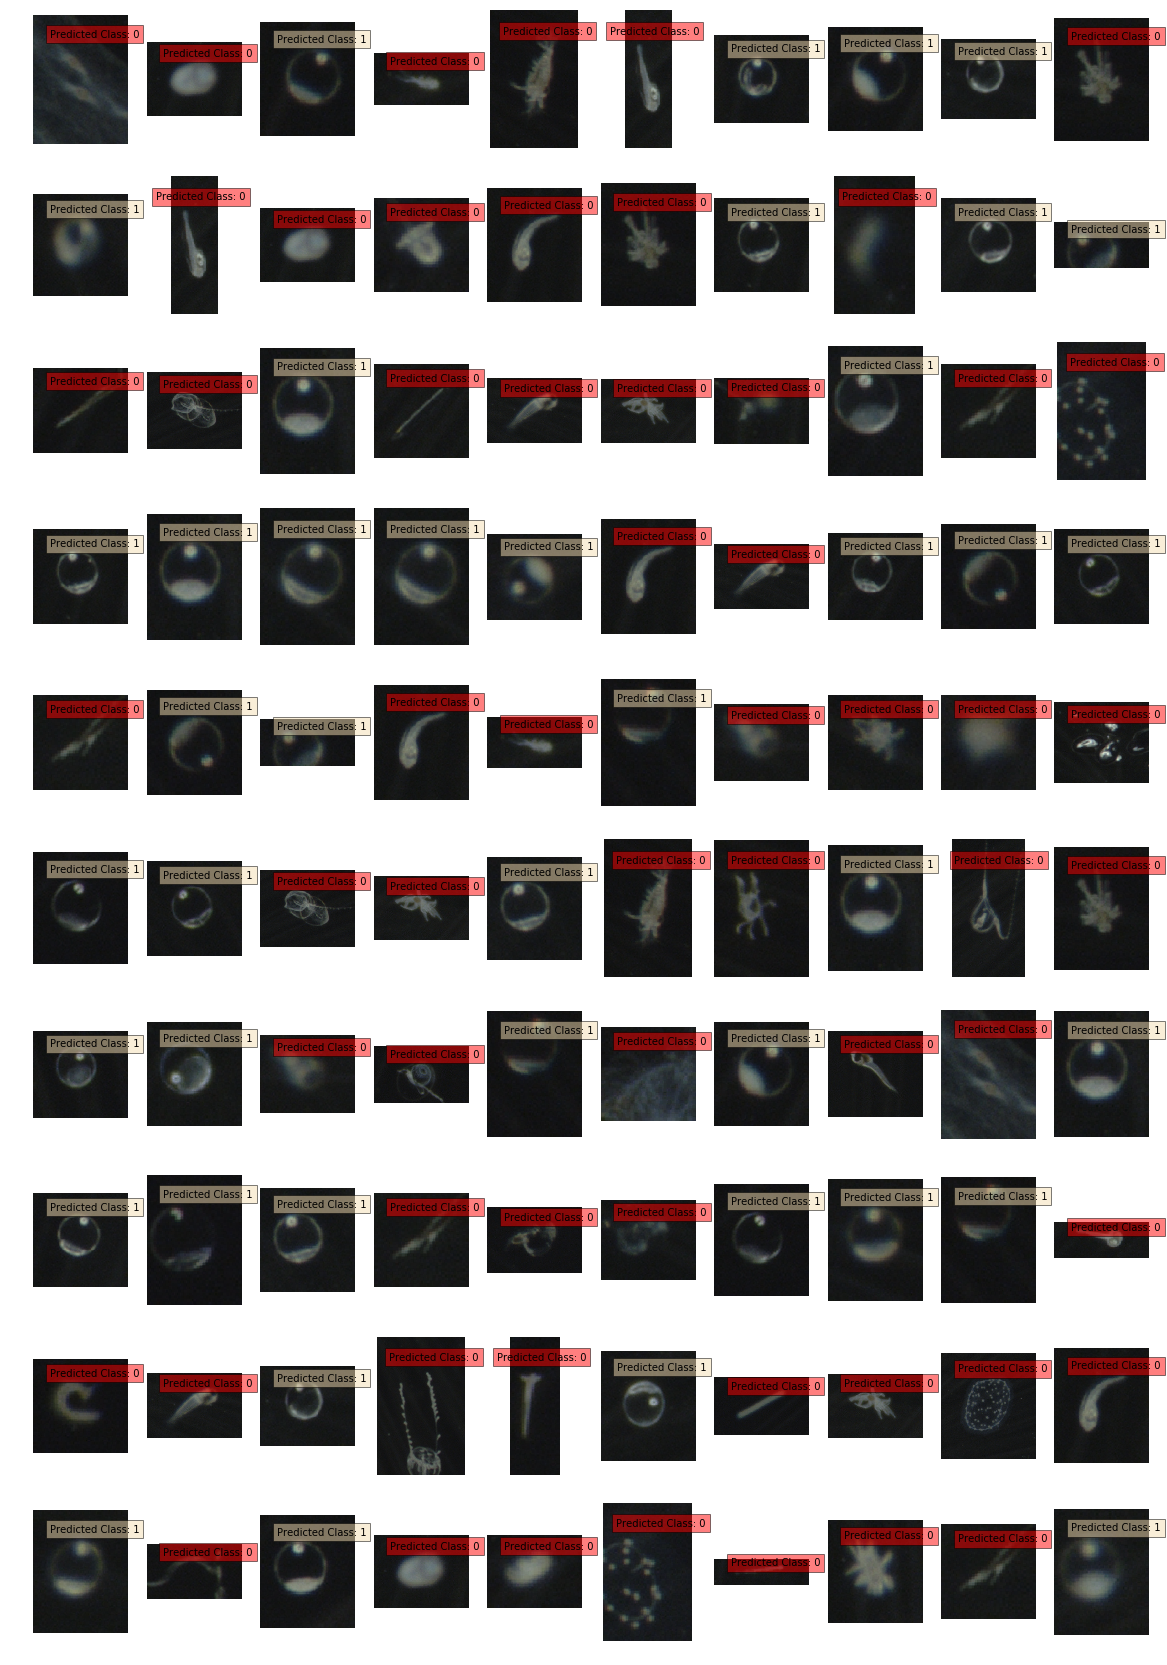

In [23]:
df = pd.DataFrame({'image': images, 'gtruth':gtruth, 'pred':predictions})
fig, axarr = plt.subplots(numRows, numCols, figsize=(20,30))
for i in range(numRows):
    for j in range(numCols):
        idx = np.random.choice(df.index)
        img = plt.imread(df.loc[idx]['image'])
        axarr[i,j].imshow(img)
        axarr[i,j].set_axis_off()
        color = 'wheat' if df.loc[idx]['pred'] == 1 else 'red'
        axarr[i,j].text(0.65, 0.85, 'Predicted Class: {}'.format(df.loc[idx]['pred']), bbox=dict(facecolor=color, alpha=0.5),
        horizontalalignment='center', verticalalignment='center', transform=axarr[i,j].transAxes)
plt.show()